# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning
## 1. Problem Definition
 For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for? 
## 2. Data
Looking at the dataset from Kaggle we see that it contains historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:

1. Train.csv - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including SalePrice which is the target variable).
2. Valid.csv - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as Train.csv).
3. Test.csv - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the SalePrice attribute, as this is what we'll be trying to predict).
> Note: You can download the dataset bluebook-for-bulldozers dataset directly from Kaggle. Alternatively, you can also download it directly from the course GitHub.
## 3. Evaluation
For this problem, Kaggle has set the evaluation metric to being root mean squared log error (RMSLE). As with many regression evaluations, the goal will be to get this value as low as possible (a low error value means our model's predictions are close to what the real values are).

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the Kaggle leaderboard.
## 4. Features
Features are different parts and attributes of the data.

During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this is to create a data dictionary.

For this dataset, Kaggle provides a data dictionary which contains information about what each attribute of the dataset means.

For example:
| Variable Name      | Description                                           | Variable Type         |
|--------------------|-------------------------------------------------------|-----------------------|
| SalesID  | unique identifier of a particular sale of a machine at auction  | Independent variable  |
| MachineID  | identifier for a particular machine; machines may have multiple sales  | Independent variable  |
| datasource  | source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs.  | Independent variable |

...


In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [5]:
# Import training and validation sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory = False)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

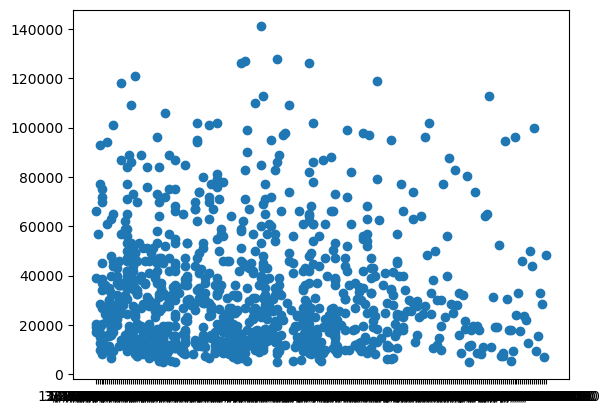

In [8]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [9]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

<Axes: ylabel='Frequency'>

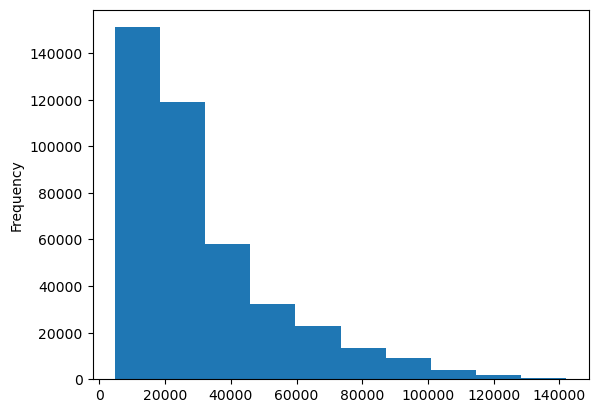

In [10]:
df.SalePrice.plot.hist()

### Parsing Dates
When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [11]:
# Import data again but this time with parse dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory = False, parse_dates=["saledate"])

In [12]:
df.saledate.dtype

dtype('<M8[ns]')

In [13]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

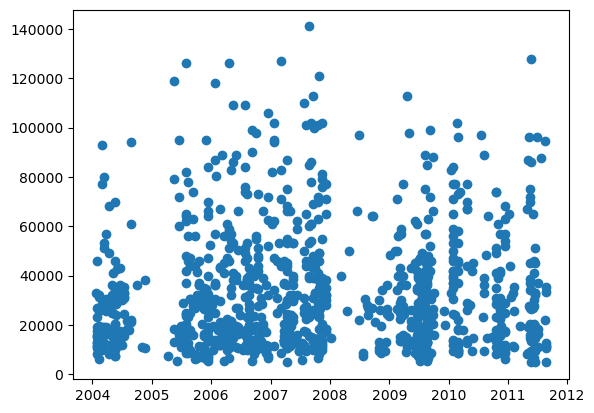

In [14]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [15]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DataFrame by saledate

In [17]:
df.sort_values(by=["saledate"], inplace=True, ascending = True)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [18]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of original DataFrame

In [19]:
df_tmp = df.copy()

### Add datetime parameters for saledate attribute

In [20]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofYear"] = df_tmp.saledate.dt.dayofyear

In [21]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [22]:
# Now We've enriched our DataFrame with datetime features , we can remove the saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

In [23]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

In [24]:
len(df_tmp)

412698

## 5. Moedelling
We've done enough EDA but let's start to do some model-driven EDA.

In [25]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42)
model.fit(df_tmp.drop("SalePrice", axis=1 ), df_tmp["SalePrice"])



ValueError: could not convert string to float: 'Low'

In [26]:
df_tmp.Coupler_System.dtype

dtype('O')

In [27]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to Categories

One way we can turn all of our data into numbers by conerting them into pandas categories.

In [28]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayofYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [29]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

In [30]:
df_tmp.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Blade_Extension             

In [31]:
# Find the Columns which contain strings 
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [32]:
# This will turn all object values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [33]:
df_tmp.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [34]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [35]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data 


In [36]:
# Export current tmp dataframe
df_tmp.to_csv("data/train_tmp.csv", index = False)

In [37]:
# Import Preprocessed data

## Fill Missing Values
### Fill Numeric missing values first

In [38]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayofYear


In [39]:
# Check for which numeric colums have null vaules
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [40]:
# Fill with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #Add a binary column which tells if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            #Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())# median is more robust to outliers.

In [41]:
# Check if there is any numeric null values left 
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        else:
            print(label + ": False")

SalesID: False
SalePrice: False
MachineID: False
ModelID: False
datasource: False
auctioneerID: False
YearMade: False
MachineHoursCurrentMeter: False
saleYear: False
saleMonth: False
saleDay: False
saleDayOfWeek: False
saleDayofYear: False
auctioneerID_is_missing: False
MachineHoursCurrentMeter_is_missing: False


In [42]:
# Check how the binary column worked
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [43]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [44]:
# Check for columns which aren't numerical
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [45]:
# Turn categorical variables into numbers and fill missing 
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Add binary column to indicate whether sample had missing value 
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        #Turn cateories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [46]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Fitting a model for the transformed data

In [47]:
len(df_tmp)

412698

In [48]:
%%time
# Instantiate model
model =  RandomForestRegressor(n_jobs = -1, random_state = 42)

# Fit the model 
model.fit(df_tmp.drop("SalePrice", axis =1), df_tmp["SalePrice"])



CPU times: total: 38min 3s
Wall time: 5min 40s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [49]:
model.score(df_tmp.drop("SalePrice", axis =1), df_tmp["SalePrice"])

0.9875468079970562

### Splitting data into train/validation sets 

In [50]:
df_tmp.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int32

In [51]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [52]:
# Split data into training and validation sets
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [53]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis = 1), df_train["SalePrice"]

X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((401125, 102), (11573, 102), (401125,), (11573,))

In [54]:
y_train

205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
393098    29000.0
400217    11000.0
400302    11000.0
400393    18000.0
393123    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation metric

In [55]:
# Create evaluation function(RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and truth values
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)

    scores = {"Training MAE" :mean_absolute_error(y_train, train_preds),
             "Valid MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE" : rmsle(y_train, train_preds),
             "Valid RMSLE" : rmsle(y_valid, val_preds),
             "Training R^2" : r2_score(y_train, train_preds),
             "Valid R^2" : r2_score(y_valid, val_preds)}
    return scores
    

## Testing our model on a subset(to tune our hyperparameters)

In [56]:
# model = RandomForestRegressor(n_jobs=-1, random_state = 42)

# model.fit(X_train, y_train)
# # take sfar too long for experimenting



In [57]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state = 42, max_samples = 10000)

In [58]:
%%time
# Cutting down on the max number of samples each estimator can see improved training time
model.fit(X_train, y_train)

CPU times: total: 1min 20s
Wall time: 13.2 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [59]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': np.float64(0.257745378256977),
 'Valid RMSLE': np.float64(0.29362638671089003),
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [60]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor Hyperparameters
rf_grid = {"n_estimators" : np.arange(10,100,10),
          "max_depth" : [None,3,5,10],
          "min_samples_split" : np.arange(2,20,2),
          "min_samples_leaf" : np.arange(1,20,2),
          "max_features" : [0.5,1,"sqrt","auto"],
          "max_samples" : [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42), param_distributions = rf_grid, n_iter=10, cv=5, verbose =True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\intel\Desktop\sample_project_1\bulldozer-price-prediction-project\env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\intel\Desktop\sample_project_1\bulldozer-price-prediction-project\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\intel\Desktop\sample_project_1\bulldozer-price-prediction-project\env\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\intel\D

CPU times: total: 4min 11s
Wall time: 1min 17s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [61]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': np.int64(50),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(7),
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [62]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 6243.437094367316,
 'Valid MAE': 7590.111221874846,
 'Training RMSLE': np.float64(0.2821751949574913),
 'Valid RMSLE': np.float64(0.306800010028582),
 'Training R^2': 0.8262485647987317,
 'Valid R^2': 0.8117618782486635}

### Train a model with best hyperparameters`

In [93]:
%%time

#Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,min_samples_split=14,min_samples_leaf=1,
                                    max_samples=None,max_depth=None,n_jobs=-1)
#Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 13min 4s
Wall time: 1min 58s


RandomForestRegressor(min_samples_split=14, n_estimators=40, n_jobs=-1)

In [64]:
show_scores(ideal_model)

{'Training MAE': 2833.6071792267608,
 'Valid MAE': 6113.9075447174155,
 'Training RMSLE': np.float64(0.13973881101893326),
 'Valid RMSLE': np.float64(0.2536280890288237),
 'Training R^2': 0.9612426836209333,
 'Valid R^2': 0.8731698600094622}

In [89]:
# from joblib import dump, load

# # Save the trained model
# dump(ideal_model, "ideal_model.joblib")

# print("Model saved successfully!")

TypeError: cannot pickle 'BufferedWriter' instances

The class of the model is shown "BufferedWriter" in above error since I tried to use 'open' function of the pickle library earlier in an attempt to save the model which transformed the class. This was removed by retraining and refitting the model.

In [95]:
from joblib import dump, load
# Temporarily disable parallel processing
# ideal_model.set_params(n_jobs=1)

# Save the model
dump(ideal_model, "ideal_model.joblib")
print("Model saved successfully!")

Model saved successfully!


In [94]:
print(type(ideal_model))

<class 'sklearn.ensemble._forest.RandomForestRegressor'>


## Make predictions on test data

In [65]:
# Import the test data
df_test = pd.read_csv("data/Test.csv", low_memory= False, parse_dates = ["saledate"])

df_test.head()


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [66]:
# Preprocessing data
# Getting the test dataset in the format of the training dataset
def preprocess_data(df):
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayofYear"] = df.saledate.dt.dayofyear

    df.drop("saledate", axis=1, inplace=True )

    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
            #Add a binary column which tells if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
            #Fill missing numeric values with median
                df[label] = content.fillna(content.median())# median is more robust to outliers.
        if pd.api.types.is_object_dtype(content):
            df_tmp[label] = content.astype("category").cat.as_ordered()
        # Fill the categorical missing data and turn categories to numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code as pandas encode missing categories as -1
            df[label] = pd.Categorical(content).codes + 1

     
    return df       
    

In [67]:
preprocess_data(df_test)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [68]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [69]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [70]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [71]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [72]:
### Predictions were not occuring earlier due to the order of the column "auctioneerID_is_missing" was different in test_preds than X_train on which the m

In [73]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Stick_Length_is_missing', 'Thumb_is_missing',
       'Pattern_Changer_is_missing', 'Grouser_Type_is_missing',
       'Backhoe_Mounting_is_missing', 'Blade_Type_is_missing',
       'Travel_Controls_is_missing', 'Differential_Type_is_missing',
       'Steering_Controls_is_missing', 'auctioneerID_is_missing'],
      dtype='object', length=102)

In [74]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

In [75]:
X_train.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [76]:
df_test.to_csv("data/updated_test.csv", index = False)
X_train.to_csv("data/X_train.csv", index = False)

In [77]:
print(X_train.columns[56])

auctioneerID_is_missing


In [78]:
column_to_move = df_test.pop('auctioneerID_is_missing')  # Remove the column
df_test.insert(56, 'auctioneerID_is_missing', column_to_move)

In [79]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [80]:
print(df_test.columns[56])

auctioneerID_is_missing


#### Finally the test DataFrame and training DataFrame have same features. So, predictions can be made now


In [81]:
# Make predictions on the test set
test_preds = ideal_model.predict(df_test)

In [82]:
# Format predictions into the same format kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,21518.451509
1,1227844,17117.114869
2,1227847,48697.146017
3,1227848,85079.904673
4,1227863,61404.354337
...,...,...
12452,6643171,53007.147609
12453,6643173,11123.513171
12454,6643184,11610.329916
12455,6643186,16914.617063


In [83]:
#Export prediction data

### Feature Importance

seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice)

In [97]:
# Find feature importance of our best model
len(ideal_model.feature_importances_)

102

In [99]:
len(X_train.columns)

102

In [104]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending = False)
         .reset_index(drop = True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()
    

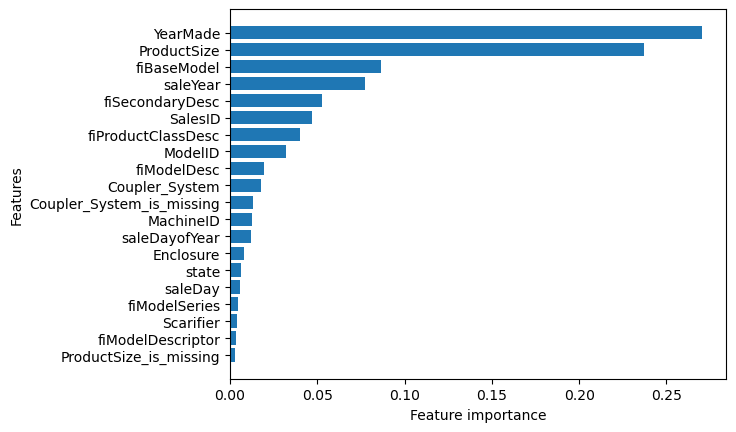

In [105]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [106]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [108]:
df["ProductSize"].value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64